In [1]:
using Pkg
Pkg.add("ForwardDiff")
Pkg.add("Flux")

 Resolving package versions...
  Updating `~/.julia/Project.toml`
  [f6369f11] + ForwardDiff v0.10.2
  Updating `~/.julia/Manifest.toml`
  [9e28174c] + BinDeps v0.8.10
  [bbf7d656] + CommonSubexpressions v0.2.0
  [163ba53b] + DiffResults v0.0.3
  [b552c78f] + DiffRules v0.0.8
  [f6369f11] + ForwardDiff v0.10.2
  [682c06a0] + JSON v0.20.0
  [77ba4419] + NaNMath v0.3.2
  [276daf66] + SpecialFunctions v0.7.0
  [90137ffa] + StaticArrays v0.10.2
  [30578b45] + URIParser v0.4.0
  [2a0f44e3] + Base64 
  [b99e7846] + BinaryProvider 
  [34da2185] + Compat 
  [864e158e] + CredentialsHandler 
  [ade2ca70] + Dates 
  [8bb1440f] + DelimitedFiles 
  [8ba89e20] + Distributed 
  [cd3eb016] + HTTP 
  [83e8ac13] + IniFile 
  [b77e0a4c] + InteractiveUtils 
  [76f85450] + LibGit2 
  [8f399da3] + Libdl 
  [37e2e46d] + LinearAlgebra 
  [56ddb016] + Logging 
  [d6f4376e] + Markdown 
  [739be429] + MbedTLS 
  [a63ad114] + Mmap 
  [44cfe95a] + Pkg 
  [de0858da] + Printf 
  [3fa0cd96] + REPL 
  [9a3f8284] + Ran

In [2]:
using Plots
using Random
using ForwardDiff:gradient,jacobian
using Flux
using Printf
using LinearAlgebra
ξ,ζ = 2,3


┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1192


(2, 3)

#### Linear regression

Generate a random 1D dataset...

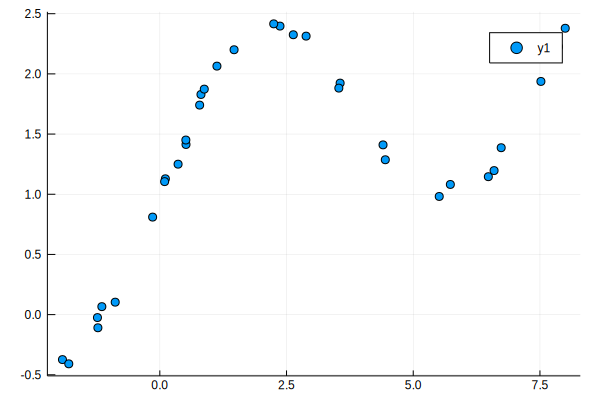

In [3]:
rng = MersenneTwister(1)

# How many points to sample
npts = 33    

# Some made-up shape
f(x) = 0.2*x + sin(0.8x) + cos(0.1x) 

# X range
xmin = -2    
xmax = 8
x = rand(rng,npts) * (xmax - xmin) .- 2.0

# Just some generic shape
y = f.(x) 

# And add some noise
noise_level = 0.05
y = y + randn(rng,size(x))*noise_level

ylim = extrema(y) .+ (-.1,.1)
scatter(x,y,ylim=ylim)

In [4]:
## Let's fit a polynomial.

# First, what basis functions?
phi(x) = [1.0, x, x^2, x^3]

# Now, what are their values at our data points?
D = phi.(x) 

33-element Array{Array{Float64,1},1}:
 [1.0, 0.360333, 0.12984, 0.0467858]     
 [1.0, 1.46517, 2.14672, 3.14532]        
 [1.0, 1.12707, 1.27029, 1.4317]         
 [1.0, -1.92091, 3.68988, -7.08793]      
 [1.0, 2.88613, 8.32974, 24.0407]        
 [1.0, 0.109682, 0.0120301, 0.00131949]  
 [1.0, 7.51916, 56.5378, 425.117]        
 [1.0, 7.99905, 63.9847, 511.817]        
 [1.0, 0.516622, 0.266898, 0.137885]     
 [1.0, 7.86666, 61.8844, 486.824]        
 [1.0, 3.55751, 12.6559, 45.0234]        
 [1.0, 2.37108, 5.62202, 13.3303]        
 [1.0, 2.24718, 5.04981, 11.3478]        
 ⋮                                       
 [1.0, 4.40396, 19.3949, 85.4143]        
 [1.0, 6.73544, 45.3662, 305.561]        
 [1.0, 0.785824, 0.61752, 0.485262]      
 [1.0, 5.51313, 30.3946, 167.569]        
 [1.0, 4.44883, 19.7921, 88.0518]        
 [1.0, -1.22174, 1.49264, -1.82361]      
 [1.0, 6.48185, 42.0144, 272.332]        
 [1.0, -1.14365, 1.30793, -1.49581]      
 [1.0, 3.53206, 12.4754, 44.0639]     

In [5]:
# And fit....
D_again = hcat(D...)'

# And fit...
a = D_again \ y

# And remember for later
#a_lin = copy(a)

4-element Array{Float64,1}:
  1.3444806139439514 
  0.7022670742954515 
 -0.23822878252304336
  0.02032433844764151

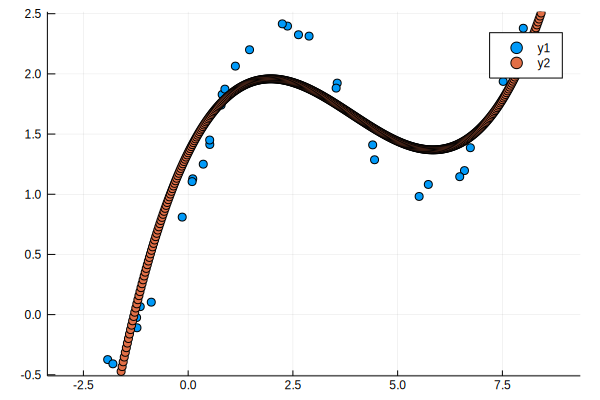

In [6]:
# And plot, at densely spaced values t.
t = xmin-1:0.025:xmax+1

fvals(a,t) = [phi(t)' * a for t in t]

scatter(x,y)
scatter!(t, fvals(a,t), ylim=ylim)


Quelle surprise.  The cubiccy shaped thing didn't fit a cubic.

Let's do better...

But before we do, let's do something silly

In [7]:
### Copied from https://github.com/FluxML/Flux.jl/blob/master/src/optimise/optimisers.jl
const ϵ = 1e-8

function apply!(o::ADAM, x, Δ)
  η, β = o.eta, o.beta
  mt, vt, βp = get!(o.state, x, (zero(x), zero(x), β))
  @. mt = β[1] * mt + (1 - β[1]) * Δ
  @. vt = β[2] * vt + (1 - β[2]) * Δ^2
  @. Δ =  mt / (1 - βp[1]) / (√(vt / (1 - βp[2])) + ϵ) * η
  o.state[x] = (mt, vt, βp .* β)
  return Δ
end



apply! (generic function with 1 method)

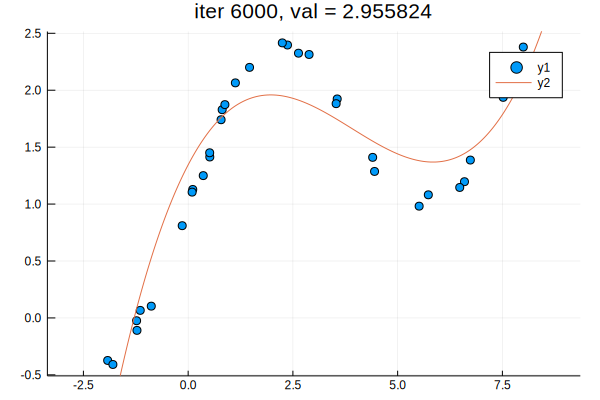

a=[1.34448, 0.702267, -0.238229, 0.0203244]


In [12]:
errors(a) = [phi(x)'*a - y for (x,y) in zip(x,y)]

sumsq(vals) = sum(abs2, vals)

loss(a) = sumsq(errors(a))

a_gd = randn(4)*0.01

println(a_gd)

scatter(x,y)
plot!(t,fvals(a_gd,t))

o = ADAM()
for iter = 0:6000
    g = gradient(loss, a_gd)
    a_gd .-= apply!(o, a_gd, g)
    if rem(iter,10) == 0
        val = @sprintf "%.6f" loss(a_gd)
        println("iter = $iter\ta=$a_gd, loss = ", val)
        IJulia.clear_output(true) #Passing true says to wait until new ouput before clearing, this prevents flickering
        scatter(x,y,ylim=ylim)
        title!("iter $iter, val = $val")
        plot!(t, fvals(a_gd,t)) |> IJulia.display
    end
end

println("a=", a_gd)


In [17]:
# Define a levenberg optimizer (without backtracking)
mutable struct xLevenberg
    lambda :: Real
    last_err :: Real
    last_x
end

function apply!(o::xLevenberg, x, r, J)
    err = sumsq(r)
    if err > o.last_err
        o.lambda *= 2 # And move towards gradient descent
        delta = x - o.last_x # Delta to reset x
    else
        # Solve least-squares system for update
        o.last_err = err
        delta = (J'*J + o.lambda*I)\(J'*r)
    end
    return delta
end


apply! (generic function with 3 methods)

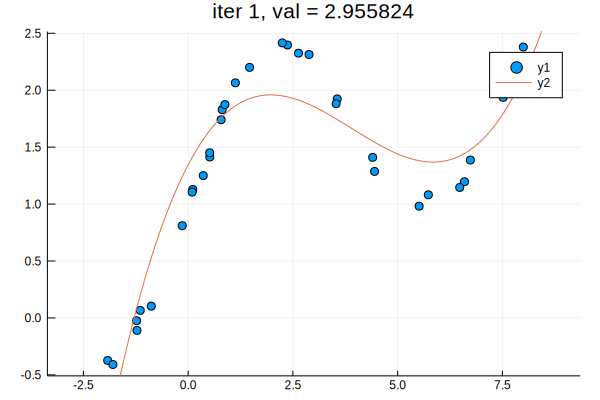

In [18]:
a_gd = randn(4)*0.01
#a_gd = copy(a_lin)

println(a_gd)

scatter(x,y)
plot!(t,fvals(a_gd,t))

o = xLevenberg(1e-4, Inf, nothing)

for iter = 0:1
    r = errors(a_gd)
    J = jacobian(errors, a_gd)
    a_gd -= apply!(o,a_gd,r,J)

    if rem(iter,1) == 0
        val = @sprintf "%.6f" loss(a_gd)
        println("iter = $iter\ta=$a_gd, loss = ", val)
        IJulia.clear_output(true) #Passing true says to wait until new ouput before clearing, this prevents flickering
        scatter(x,y,ylim=ylim)
        title!("iter $iter, val = $val")
        plot!(t, fvals(a_gd,t)) |> IJulia.display
    end
end

#println("a=", a_gd)

#### Things to try next

##### Make the function fit better.  

We had ``f(x) = 0.2*x + sin(0.8x) + cos(0.1x)``.  
We tried a + b x + c x^2 + d x^3
1. We could try a bigger polynomial...
2. Or something closer ``a + b x + c sin(x) + d sin(2x)``
3. Or something nonlinear ``a + b sin(w x + p)``

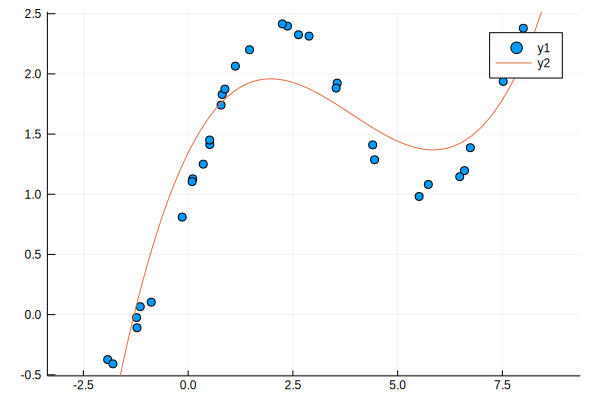

In [19]:
# A copy from above...
phi(x) = [1.0, x, x^2, x^3]

# Encapsulate everything in one test function:
function test(phi)
    D = [phi(x) for x in x]
    D_again = hcat(D...)'
    # And fit...
    a = D_again \ y
    scatter(x,y)
    plot!(t, fvals(a,t), ylim=ylim)
end

test(phi)

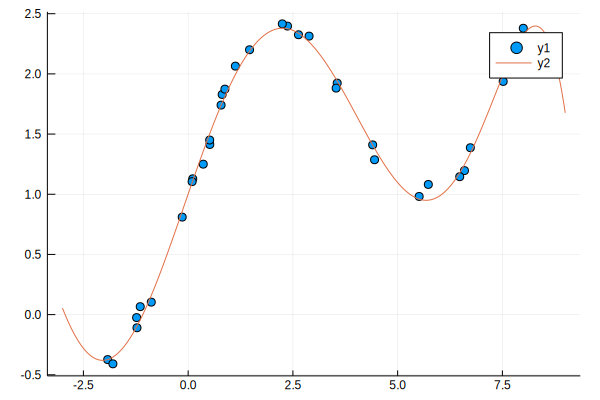

In [20]:
phi(x) = x .^ (0:6)
test(phi)

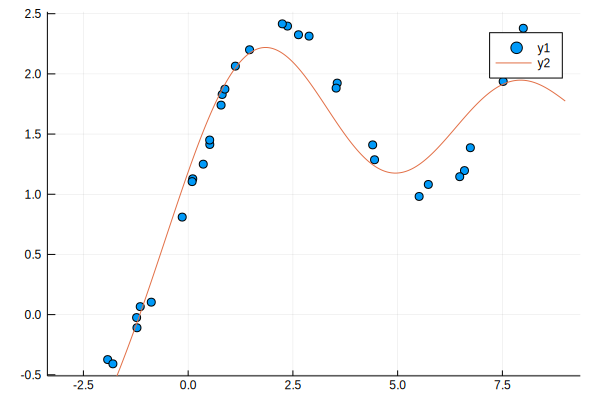

In [21]:
phi(x) = [1, x, x.^2, x^3, sin(x)]
test(phi)

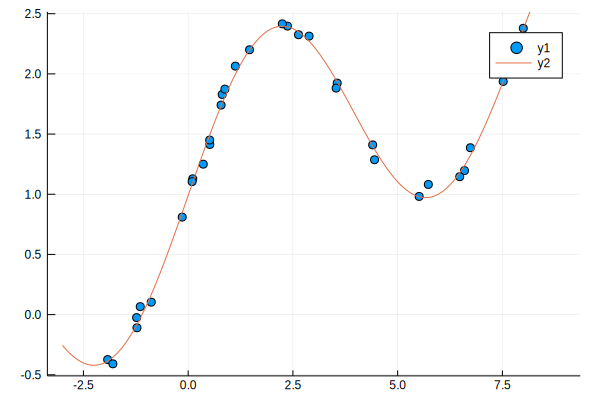

In [22]:
phi(x) = [1, x, x.^2, x^3, sin(0.8x)]
test(phi)

In [24]:
# New, nonlinear model: not a4 sin(x) but sin(a4 x)

nl_phi(x,a) = a[1] + a[2] * x + a[3]*x^2 + sin(a[4]*x)

nl_errors(a) = [nl_phi(x,a) - y for (x,y) in zip(x,y)]

nl_loss(a) = sumsq(nl_errors(a))

nl_fvals(a,t) = [nl_phi(t,a) for t in t]


nl_fvals (generic function with 1 method)

Optimize with ADAM:

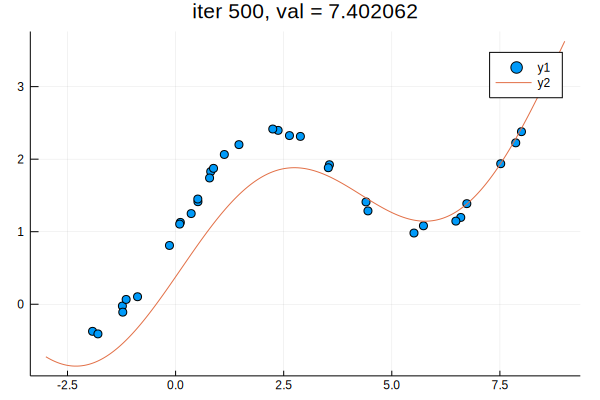

In [28]:
a_gd = [0, 0, 0, 1.0]

println(a_gd, nl_loss(a_gd))

o_adam = ADAM()
for iter = 0:500
    a_gd .-= apply!(o_adam, a_gd, gradient(nl_loss,a_gd))

    if rem(iter,1) == 0
        val = @sprintf "%.6f" nl_loss(a_gd)
        #println("iter = $iter\ta=$a_gd, loss = ", val) |> IJulia.display
        IJulia.clear_output(true) #Passing true says to wait until new ouput before clearing, this prevents flickering
        scatter(x,y)
        title!("iter $iter, val = $val")
        plot!(t, nl_fvals(a_gd,t)) |> IJulia.display
    end
end

#println("a=", a_gd)

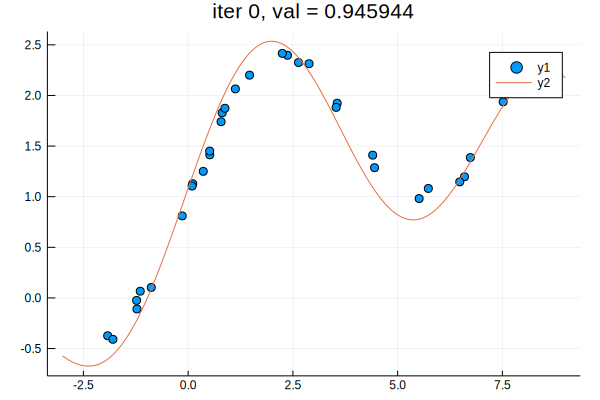

In [30]:
# Optimize with LM
a_gd = [0, 0, 0, 1.0]

println(a_gd, nl_loss(a_gd))

o = xLevenberg(1e-4,Inf,nothing)
for iter = 0:0
    r = nl_errors(a_gd)
    J = jacobian(nl_errors, a_gd)
    a_gd -= apply!(o,a_gd,r,J)

    if rem(iter,1) == 0
        val = @sprintf "%.6f" nl_loss(a_gd)
        #println("iter = $iter\ta=$a_gd, loss = ", val) |> IJulia.display
        IJulia.clear_output(true) #Passing true says to wait until new ouput before clearing, this prevents flickering
        scatter(x,y)
        title!("iter $iter, val = $val")
        plot!(t, nl_fvals(a_gd,t)) |> IJulia.display
    end
end

#println("a=", a_gd)